## Project: Build a Traffic Sign Recognition Classifier
### Stage1: Import related Library and testing data

In [63]:
# Stage1: Load the Library

from sklearn.utils import shuffle
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import os, sys
import matplotlib.image as mpimg
from PIL import Image
from itertools import compress
import random
import math
import cv2

In [64]:
# Load pickled data 

train_file = 'traffic-signs-data/train.p'
validate_file = 'traffic-signs-data/valid.p'
test_file = 'traffic-signs-data/test.p'

with open(train_file, mode='rb') as f:
    train = pickle.load(f)
with open(validate_file, mode='rb') as f:
    valid = pickle.load(f)
with open(test_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

### Stage2: Resize the images

In [65]:
# Resize the images inside 'images' directory
# This step should have been part of "Stage 3", but
# I had a problem where values from session loaded from checkpoint
# was different from when the session was used directly to predict.
# Resetting the computer resolved this issue.

size = 32, 32
dirname = 'pics'
try:
    os.mkdir(dirname+'/thumbs')
except:
    print(dirname+'/thumbs already exists, now creating images...')
for infile in os.listdir(dirname):
    if infile.endswith(".png"):
        outfile = dirname+'/thumbs/'+os.path.splitext(infile)[0] + "t.jpg"
        if infile != outfile:
            try:
                im = Image.open(dirname+'/'+infile)
                im.thumbnail(size, Image.ANTIALIAS)
                im.save(outfile, "JPEG")
                print('created: '+outfile)
            except IOError:
                print("cannot create thumbnail for '%s'" % infile)
                

dirname = 'pics/thumbs'
sample_images = []
for img in os.listdir(dirname):
    image = mpimg.imread(dirname+'/'+img)
    sample_images.append(image)

answers = [4, 25, 14, 34, 3]
    
def display_predictions(images, answers, converter=None, height=32):
    signnames = pd.read_csv('signnames.csv')
    if converter is not None:
        images = converter(images)
    for i, answer in enumerate(answers):
        a = fig.add_subplot(1, 5, i+1)
        plt.imshow(images[i])
        plt.text(-1, height+8, signnames['SignName'][answer], va='top')

pics/thumbs already exists, now creating images...
created: pics/thumbs/0t.jpg
created: pics/thumbs/1t.jpg
created: pics/thumbs/2t.jpg
created: pics/thumbs/3t.jpg
created: pics/thumbs/4t.jpg


### Provide a Basic Summary of Data Set Using Python,Numpy and/or Pandas

In [66]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

n_train = len(X_train)
n_valid = len(X_valid)
n_test = len(X_test)
image_shape = X_train[0].shape
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Stage3: Include an exploratory visualization of the dataset

30


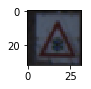

In [67]:
# Visualizations will be shown in the notebook.
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image, cmap="gray")
print(y_train[index])

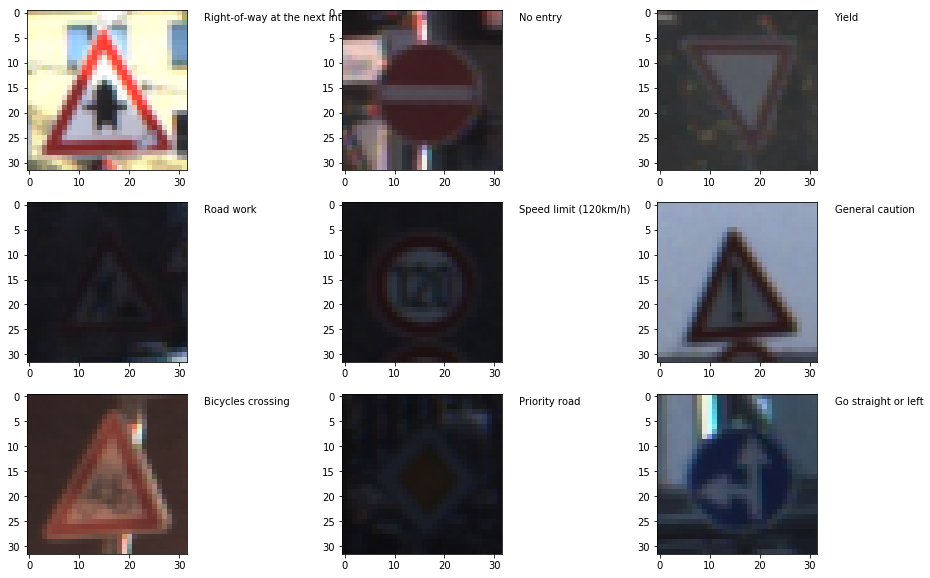

In [68]:
# Sanity check
sample_size = 9
X_sample, y_sample = shuffle(X_train,  y_train)
X_sample = X_sample[:sample_size]
y_sample = y_sample[:sample_size]
signnames = pd.read_csv('signnames.csv')
fig = plt.figure(figsize=(16, 10))

for i, (X, y) in enumerate(zip(X_sample, y_sample)):
    a = fig.add_subplot(math.ceil(float(sample_size)/3.), 3, i+1)
    plt.imshow(X)
    plt.text(35, 0, signnames['SignName'][y], va='top')

### There are various aspects to consider when thinking about this problem:

Neural network architecture (is the network over or underfitting?)
Play around preprocessing techniques (normalization, rgb to grayscale, etc)
Number of examples per label (some have more than others).
Generate fake data.

### Stage4 : Preprocess the Data Set (normalization, grayscale, etc.)
Use the code cell (or multiple code cells if necessary) to implement the first step of your project.

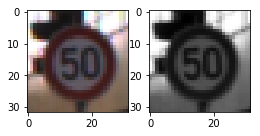

In [69]:
tf.reset_default_graph() 

X_train, y_train = shuffle(X_train, y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)
X_test, y_test = shuffle(X_test, y_test)

def grayscale(image):
    logits = tf.image.rgb_to_grayscale(image)
    return logits

def normalize(image, min_val, max_val, min_color=0, max_color=255):
    """ Normalize image colors between min and max values
    
    a + ( ( (image_data - grayscale_min)*(b - a) )/( grayscale_max - grayscale_min ) )
    """
    output = tf.divide(
        tf.multiply(tf.subtract(image, min_color), tf.subtract(max_val, min_val)),
        (max_color - min_color)
    )
    return output
    
def preprocess(inputs):
    logits = grayscale(inputs)
    logits = normalize(logits, 0.1, 0.9)
    return logits

X = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
preprocess_test = preprocess(X)

## Testing preprocess step
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    X_few, y_few = X_train[:1], y_train[:1]
    results = sess.run(preprocess_test, feed_dict={X: X_few, y: y_few})
image = results[0,:,:,0]
fig = plt.figure(figsize=(4, 4))
a = fig.add_subplot(1, 2, 1)
plt.imshow(X_train[0])
a = fig.add_subplot(1, 2, 2)
plt.imshow(image, cmap="gray")

### Stage5: Design a Convolutional Neural Network
The following CNN structure is:
### INPUT->CONV->RELU->POOL->CONV->RELU->POOL->FLAT->FC->RELU->FC->OUTPUT

In [70]:
# design the CNN architecture
def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal((5, 5, 1, 6), mean = mu, stddev = sigma), name='conv1_W')
    conv1_b = tf.Variable(tf.zeros((6)), name='conv1_b')
    strides = [1, 1, 1, 1]
    conv1 = tf.nn.conv2d(x, conv1_W, strides=strides,use_cudnn_on_gpu=True,padding='VALID', name='conv1') + conv1_b
    
    # Activation.
    conv1 = tf.nn.relu(conv1, name='conv1_actd')

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    strides = [1, 2, 2, 1]
    conv1 = tf.nn.max_pool(conv1, ksize=strides, strides=strides, padding='VALID', name='pool1')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal((5, 5, 6, 16), mean = mu, stddev = sigma), name='conv2_W')
    conv2_b = tf.Variable(tf.zeros((16)), name='conv2_b')
    strides = [1, 1, 1, 1]
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=strides,use_cudnn_on_gpu=True,padding='VALID', name='conv2') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2, name='conv2_actd')

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    strides = [1, 2, 2, 1]
    conv2 = tf.nn.max_pool(conv2, ksize=strides, strides=strides, padding='VALID', name='pool2')

    # Flatten. Input = 5x5x16. Output = 400.
    flat1 = tf.contrib.layers.flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    flat2_W = tf.Variable(tf.truncated_normal((400, 120), mean = mu, stddev = sigma), name='flat2_W')
    flat2_b = tf.Variable(tf.zeros((120)), name='flat2_b')
    flat2 = tf.add(tf.matmul(flat1, flat2_W), flat2_b, name='flat2')
    
    # Activation.
    flat2 = tf.nn.relu(flat2, name='flat2_actd')

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    flat3_W = tf.Variable(tf.truncated_normal((120, 84), mean = mu, stddev = sigma), name='flat3_W')
    flat3_b = tf.Variable(tf.zeros((84)), name='flat3_b')
    flat3 = tf.add(tf.matmul(flat2, flat3_W), flat3_b, name='flat3')
    
    # Activation.
    flat3 = tf.nn.relu(flat3, name='flat3_actd')

    # Layer 5: Fully Connected. Input = 84. Output = n_classes.
    flat4_W = tf.Variable(tf.truncated_normal((84, n_classes), mean = mu, stddev = sigma), name='flat4_W')
    flat4_b = tf.Variable(tf.zeros((n_classes)), name='flat4_b')
    flat4 = tf.add(tf.matmul(flat3, flat4_W), flat4_b, name='output')
   
    logits = flat4
    return logits


### Stage6: Train,Validate and Test the Model
### Goal: the final validation accuracy should be 0.93 or higher.
A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

Training...

EPOCH 1 ...
Validation Accuracy = 0.740

EPOCH 2 ...
Validation Accuracy = 0.823

EPOCH 3 ...
Validation Accuracy = 0.866

EPOCH 4 ...
Validation Accuracy = 0.879

EPOCH 5 ...
Validation Accuracy = 0.888

EPOCH 6 ...
Validation Accuracy = 0.895

EPOCH 7 ...
Validation Accuracy = 0.915

EPOCH 8 ...
Validation Accuracy = 0.905

EPOCH 9 ...
Validation Accuracy = 0.905

EPOCH 10 ...
Validation Accuracy = 0.911

Model saved
Wall time: 4min


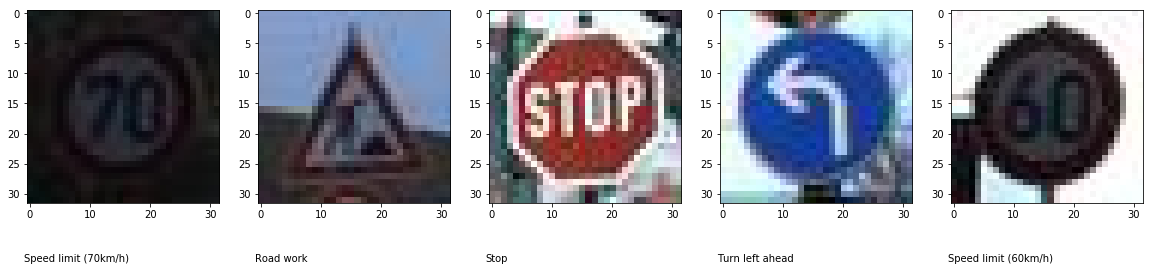

In [76]:

%%time
tf.reset_default_graph()
EPOCHS = 10  #lower the EPOCHS, so to shorten the test time
BATCH_SIZE = 96

rate = 0.001

X = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
logits = preprocess(X)
logits = LeNet(logits)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y, name='xent')
loss_operation = tf.reduce_mean(cross_entropy, name='loss')
optimizer = tf.train.AdamOptimizer(learning_rate = rate, name='opt')
training_operation = optimizer.minimize(loss_operation)

def evaluate(X_data, y_data, one_hot_y, logits):
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={X: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={X: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid, one_hot_y, logits)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet.ckpt')
    print("Model saved")
    
    # Making sure the model can be used to predict new images.
    # This step was added since there was a problem (small Tensorflow bug?) with
    # saving and loading checkpoint where somehow `session.run` returned
    # different results than using the original logits (i.e. not loaded from checkpoint).
    # Resetting the computer resolved this issue. Weird.
    y_label = tf.argmax(logits, 1, name='output_label')
    machine_answers = sess.run(y_label, feed_dict={X: sample_images, y: np.zeros(len(sample_images))})
    fig = plt.figure(figsize=(20, 10))
    display_predictions(sample_images, machine_answers)


## Load and output the images

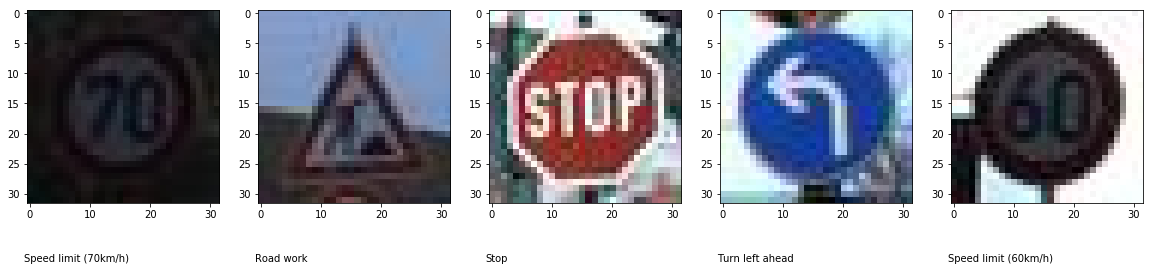

In [77]:
dirname = 'pics/thumbs'
fig = plt.figure(figsize=(20, 10))
images = []
for img in os.listdir(dirname):
    image = mpimg.imread(dirname+'/'+img)
    images.append(image)

answers = [4, 25, 14, 34, 3]
display_predictions(images, answers)

### Stage7: Predict the sign type for each image
This is needed so we can try creating a graph from scratch and load the variables.

INFO:tensorflow:Restoring parameters from ./lenet.ckpt


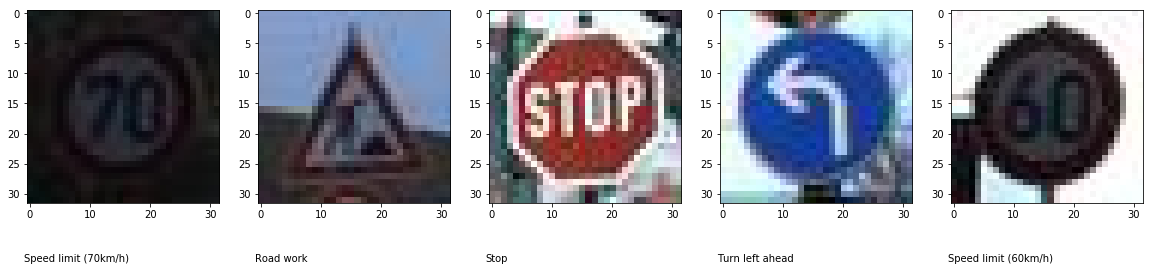

In [78]:
# This is needed so we can try creating a graph from scratch and load the variables.
tf.reset_default_graph() 

X = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
logits = preprocess(X)
logits = LeNet(logits)
y_label = tf.argmax(logits, 1, name='output_label')
y_data = np.zeros(len(images))

saver = tf.train.Saver() 

with tf.Session() as sess:
    saver.restore(sess, './lenet.ckpt')
    machine_answers = sess.run(logits, feed_dict={X: images, y: y_data})

machine_answers_label = np.argmax(machine_answers, axis=1)
fig = plt.figure(figsize=(20, 10))
display_predictions(images, machine_answers_label)


### Stage8: Analyze Performance

In [79]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32,(None,32,32,3))
y = tf.placeholder(tf.int32,(None))
one_hot_y = tf.one_hot(y,43)
logits = preprocess(X)
logits = LeNet(logits)
saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess,'./lenet.ckpt')
    test_accuracy = evaluate(images,answers,one_hot_y,logits)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet.ckpt
Test Accuracy = 1.000


### Stage9: Give out top five probabilities for each image from the Internet

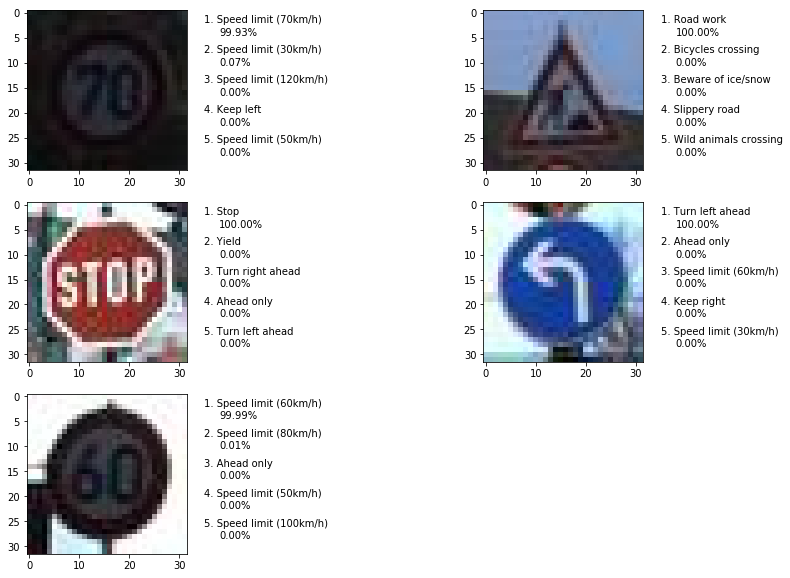

In [80]:
tf.reset_default_graph()
with tf.Session() as sess:
    top5 = sess.run(tf.nn.top_k(tf.nn.softmax(tf.constant(machine_answers)), k=5))
    signnames = pd.read_csv('signnames.csv')
    fig = plt.figure(figsize=(15, 10))
    for i, indices in enumerate(top5.indices):
        a = fig.add_subplot(3,2,i+1)
        plt.imshow(images[i])
        for j, index in enumerate(indices):
            plt.text(35,(j*6)+2, "{}. {}".format(j+1, signnames['SignName'][index]))
            plt.text(38, (j*6)+4.5, "{:.2%}".format(top5.values[i][j]))